https://discourse.pymc.io/t/mixture-model-with-boxcox-transformation/988

In [1]:
%pylab inline
import pymc3 as pm
import theano.tensor as tt

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


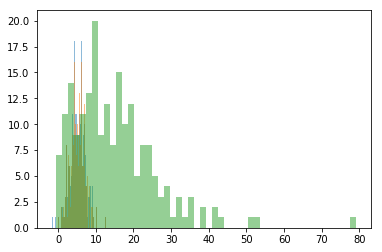

In [11]:
from scipy import special
y = np.random.normal(5., 2., size=200)
lam = 2.
y_tr = (np.power(y, lam) - 1.) / lam
plt.hist(y, bins=50, alpha=.5)
inv_boxcox = lambda x: np.power(x * lam + 1., 1. / lam)
plt.hist(inv_boxcox(y_tr), bins=50, alpha=.5);
plt.hist(y_tr, bins=50, alpha=.5);
# plt.hist(special.boxcox(y, lam), bins=50, alpha=.5);


In [12]:
import theano.tensor as tt
from pymc3.distributions.transforms import ElemwiseTransform

class BoxCox(ElemwiseTransform):
    """Box-Cox transformation from real line to real line"""

    name = "boxcox"

    def __init__(self, lam):
        self.lam = tt.as_tensor_variable(lam)

    def backward(self, x):
        return tt.power(x * self.lam + 1, 1. / self.lam)

    def forward(self, y):
        return (tt.power(y, self.lam) - 1.) / self.lam

    def forward_val(self, y, point=None):
        lam = draw_values([self.lam], point=point)
        return (np.power(y, lam) - 1.) / lam
    
boxcox = BoxCox(lam)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, mu]
100%|██████████| 1000/1000 [00:01<00:00, 743.29it/s]


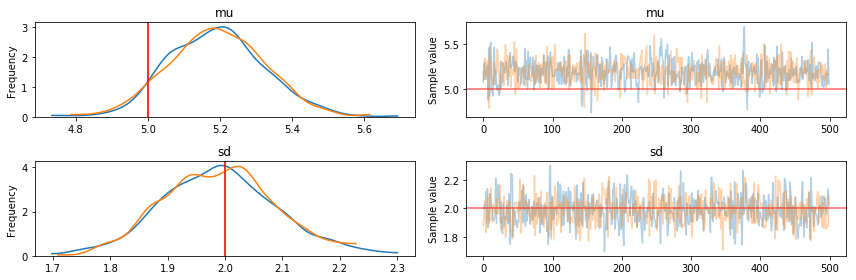

In [13]:
with pm.Model() as m:
    mu = pm.Normal('mu', 0., 100.)
    sd = pm.HalfNormal('sd', 5.)
    obs = pm.Normal('y', mu, sd, observed=boxcox.backward(y_tr))
    trace = pm.sample()

pm.traceplot(trace, lines=dict(mu=5., sd=2.));

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, mu]
100%|██████████| 1000/1000 [00:01<00:00, 604.19it/s]
The acceptance probability does not match the target. It is 0.8844527235646388, but should be close to 0.8. Try to increase the number of tuning steps.


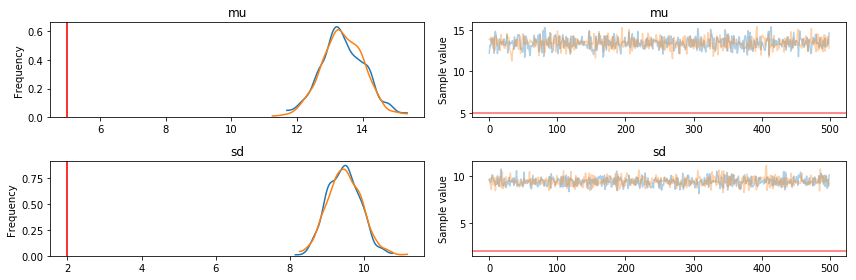

In [10]:
with pm.Model() as m:
    mu = pm.Normal('mu', 0., 100.)
    sd = pm.HalfNormal('sd', 5.)
    obs = pm.Normal('y', mu, sd, observed=y_tr, transform=boxcox)
    trace = pm.sample()
    
pm.traceplot(trace, lines=dict(mu=5., sd=2.));